# User-Item Attention Matrix Factorization **AttMFui**



In [1]:
import torch
import torch.nn as nn 
from utils import get_mse_data, get_mse_train_loader

## Data

In [2]:
num_users, num_items, users_train, items_train, ratings_train, users_test, items_test, ratings_test, train_candidates, test_candidates = get_mse_data()

In [3]:
train_loader = get_mse_train_loader(users_train, items_train, ratings_train, shuffle=True)

In [4]:
len(train_loader)

98

## Model Config

In [5]:
from gcn.attention import AttMFui
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 10
model = AttMFui(num_users, num_items, n_factors)
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
print(f"device: {device}, n_factors: {n_factors}, learning_rate: {learning_rate}, weight_decay: {weight_decay}")

device: cuda, n_factors: 10, learning_rate: 0.01, weight_decay: 1e-05


## Train

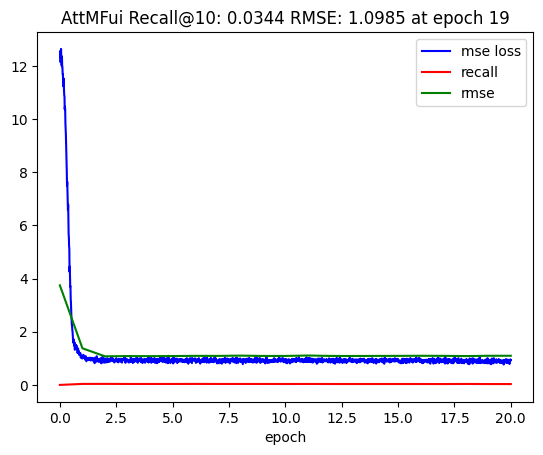

AttMFui Recall@10: 0.0344 RMSE: 1.0985 at epoch 19


In [6]:
from gcn.train import evaluate_ranking, evaluate_rating
from gcn.visualize import Animator
ani = Animator()
num_epochs = 20
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
rmse_list = []
recall_list = []

with torch.no_grad():
    recall = evaluate_ranking(
        model,
        test_candidates,
        train_candidates,
        num_users,
        num_items,
        top_k = topk
    )
    recall_list.append(recall)
    rmse = evaluate_rating(
        model,
        users_test, 
        items_test, 
        ratings_test
    )
    rmse_list.append(rmse)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        users, items, ratings = values[0].to(device), values[1].to(device), values[2].to(device)
        # Forward pass
        scores = model(users, items)
        loss = loss_fn(scores, ratings.float())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        recall = evaluate_ranking(
            model,
            test_candidates,
            train_candidates,
            num_users,
            num_items,
            top_k = topk
        )
        recall_list.append(recall)
        rmse = evaluate_rating(
            model,
            users_test, 
            items_test, 
            ratings_test
        )
        rmse_list.append(rmse)
        epoch_list.append(epoch+1)


    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
    ani.ax.plot(epoch_list, recall_list, color='r', label='recall')
    ani.ax.plot(epoch_list, rmse_list, color='g', label='rmse')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'AttMFui Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'AttMFui Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')

ani.close()

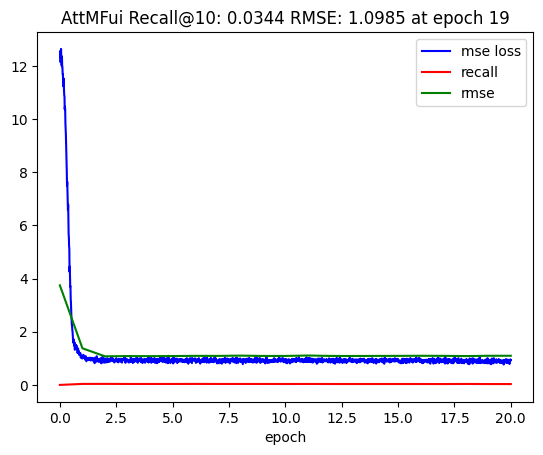

In [7]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
plt.plot(epoch_list, recall_list, color='r', label='recall')
plt.plot(epoch_list, rmse_list, color='g', label='rmse')
plt.xlabel("epoch")
plt.legend()
plt.title(f'AttMFui Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
plt.show()

In [8]:
recall_list

[0.001639344262295082,
 0.03934426229508197,
 0.040983606557377046,
 0.03770491803278689,
 0.03770491803278689,
 0.03770491803278689,
 0.03934426229508197,
 0.03770491803278689,
 0.03770491803278689,
 0.03770491803278689,
 0.036065573770491806,
 0.03770491803278689,
 0.036065573770491806,
 0.036065573770491806,
 0.036065573770491806,
 0.036065573770491806,
 0.036065573770491806,
 0.03442622950819672,
 0.03770491803278689,
 0.03442622950819672,
 0.03442622950819672]

In [9]:
rmse_list

[3.7455965255095456,
 1.3788373027562857,
 1.0770775502761056,
 1.0856818577487661,
 1.0838492644365794,
 1.0873606844708588,
 1.0947125695156934,
 1.0927301284075877,
 1.1031970078954032,
 1.0910899376341672,
 1.0915228375235722,
 1.1072270728308766,
 1.0921707195690145,
 1.089374126580611,
 1.0920463918361263,
 1.094354462488076,
 1.0973276752922438,
 1.0950550467881583,
 1.086160156696036,
 1.0975515512511513,
 1.0985458407415278]

In [10]:
# max(recall_list), min(rmse_list) 
print(f'AttMFui Max Recall@{topk}: {max(recall_list):.4f} at epoch {recall_list.index(max(recall_list))}')
print(f'AttMFui Min RMSE: {min(rmse_list):.4f} at epoch {rmse_list.index(min(rmse_list))}')

AttMFui Max Recall@10: 0.0410 at epoch 2
AttMFui Min RMSE: 1.0771 at epoch 2
